In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
!nvidia-smi

Fri Jul 30 15:34:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla M60    On   | 00000000:04:00.0 Off |                    0 |
| N/A   24C    P8    15W / 150W |      0MiB /  7618MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## load data

In [2]:
galstar = pd.read_csv("/g/g15/ahlquist/Documents/challenge_setup/data_and_information/galstar.csv")

galstar = galstar.drop("Unnamed: 0", axis=1)

In [3]:
y = galstar['y'].to_numpy().reshape(-1, 1)
X = galstar.drop('y', axis=1)

# reshape X into a three dimensional image array
X = X.to_numpy().reshape(-1,8,26,26)

In [4]:
def displaySingleChannel(image):
    plt.imshow(image,cmap='magma')
    plt.show()
    
def displayAllChannels(imageChannels):
    for i in range(8):
        displaySingleChannel(imageChannels[i])
        
#displayAllChannels(X[0,:,:,:])

In [5]:
# Normalize each image
def histogramStretch(image):
    min_val, max_val = (np.amin(image), np.amax(image))
    image = image - min_val #* vec_one_        #background subtract
    image = image / (max_val - min_val)       #normalize between 0 and 1
    return image

for i in tqdm(range(len(X))):
    for j in range(1):
        X[i,j,:,:] = histogramStretch(X[i,j,:,:])

100%|██████████| 31798/31798 [00:01<00:00, 28477.78it/s]


In [6]:
from sklearn.model_selection import train_test_split

# train_size = .9
# val_size = .05

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

# Let 5% of the test set be validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05)


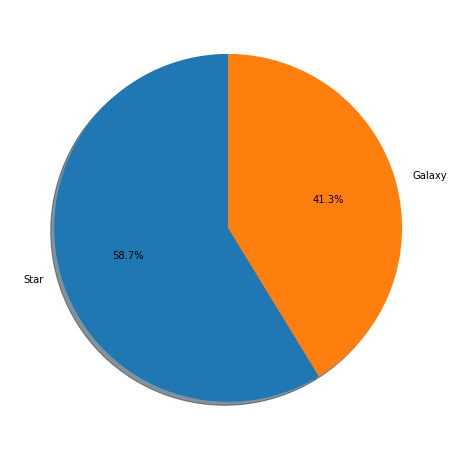

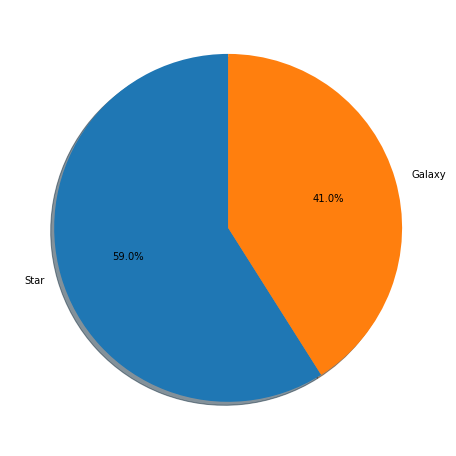

In [7]:
label = 'Star','Galaxy'
plt.figure(figsize = (8,8))
plt.pie(np.bincount(y_train.reshape(-1)), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

label = 'Star','Galaxy'
plt.figure(figsize = (8,8))
plt.pie(np.bincount(y_val.reshape(-1)), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [8]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision as tv
from torch.utils.data import DataLoader,TensorDataset
from torch import Tensor

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

device = torch.device(device)
print(device)

cuda:0


In [9]:
train_tensor = TensorDataset(Tensor(X_train),Tensor(y_train))
val_tensor   = TensorDataset(Tensor(X_val),  Tensor(y_val))
test_tensor  = TensorDataset(Tensor(X_test), Tensor(y_test))

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_tensor,batch_size=int(31798*.75*.5),shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset=val_tensor,batch_size=64,shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_tensor,batch_size=64,shuffle=False)

In [11]:
class EthanNet(nn.Module):
    def __init__(self):
        super().__init__()        
        
#       self.conv1 = nn.Conv2d(8,16,3,stride = 1,padding=0)#16,24x24 ()
        self.conv1 = nn.Conv2d(8,16,3,stride = 1,padding=0)#16,24x24 ()
        self.conv2 = nn.Conv2d(16,32,3,stride =1,padding = 0) #22x22,32#  batchnorm
        self.fc1 = nn.Linear(22*22*32,100)
        self.fc2 = nn.Linear(100,20) 
        self.fc3 = nn.Linear(20,1)
        
    def forward(self,x):
        x = torch.nn.functional.relu(self.conv1(x)) #leaky relu, elu
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) #binary, 0,1
        
        return x
model = EthanNet().to(device)

In [12]:
from sklearn.metrics import accuracy_score
def eval(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred>0.5)
    return accuracy    

## Train

In [13]:
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0002,weight_decay = 1e-5)

num_epochs = 600
output2 = []
Acc = []
Val=[]

for val_img,val_lab in val_loader:
    val_img,val_lab = val_img.to(device),val_lab.to(device)
    

for epoch in tqdm(range(num_epochs)):
    for img,lab in train_loader:
          
        img = img.to(device)
        lab= lab.to(device)
        
        out = model(img)
        
        val_out = model(val_img)
        valacc = eval(val_lab.cpu(),val_out.cpu())
        Val.append(valacc)
        acc = eval(lab.cpu(),out.cpu())
        
        Acc.append(acc)
        loss = criterion(out,lab)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 40 ==0:
  
        print(f'Epoch:{epoch+1},train-acc: {acc*100:.5f}%,val-acc: {valacc*100:.5f}%')        
    
    
    output2.append(loss.item())

  0%|          | 1/600 [00:01<13:51,  1.39s/it]

Epoch:1,train-acc: 57.89158%,val-acc: 56.52174%


  7%|▋         | 41/600 [00:47<10:43,  1.15s/it]

Epoch:41,train-acc: 89.78736%,val-acc: 91.30435%


 14%|█▎        | 81/600 [01:33<09:59,  1.15s/it]

Epoch:81,train-acc: 91.16502%,val-acc: 91.30435%


 20%|██        | 121/600 [02:19<09:15,  1.16s/it]

Epoch:121,train-acc: 91.04522%,val-acc: 95.65217%


 27%|██▋       | 161/600 [03:06<08:27,  1.16s/it]

Epoch:161,train-acc: 92.42288%,val-acc: 95.65217%


 34%|███▎      | 201/600 [03:52<07:42,  1.16s/it]

Epoch:201,train-acc: 91.16502%,val-acc: 95.65217%


 40%|████      | 241/600 [04:39<06:58,  1.17s/it]

Epoch:241,train-acc: 92.42288%,val-acc: 95.65217%


 47%|████▋     | 281/600 [05:26<06:13,  1.17s/it]

Epoch:281,train-acc: 91.88380%,val-acc: 91.30435%


 54%|█████▎    | 321/600 [06:12<05:28,  1.18s/it]

Epoch:321,train-acc: 92.03354%,val-acc: 91.30435%


 60%|██████    | 361/600 [06:59<04:36,  1.16s/it]

Epoch:361,train-acc: 92.81222%,val-acc: 91.30435%


 67%|██████▋   | 401/600 [07:45<03:49,  1.15s/it]

Epoch:401,train-acc: 92.75232%,val-acc: 95.65217%


 74%|███████▎  | 441/600 [08:32<03:04,  1.16s/it]

Epoch:441,train-acc: 92.99191%,val-acc: 95.65217%


 80%|████████  | 481/600 [09:19<02:19,  1.18s/it]

Epoch:481,train-acc: 92.87212%,val-acc: 91.30435%


 87%|████████▋ | 521/600 [10:05<01:31,  1.16s/it]

Epoch:521,train-acc: 93.83049%,val-acc: 95.65217%


 94%|█████████▎| 561/600 [10:52<00:45,  1.15s/it]

Epoch:561,train-acc: 93.26146%,val-acc: 95.65217%


100%|██████████| 600/600 [11:37<00:00,  1.16s/it]


## Save / Load a model

In [14]:
PATH = "/g/g15/ahlquist/Documents/asteroids/model_save.pth"

In [15]:
torch.save(model.state_dict(), PATH)

In [ ]:
model = torch.load(PATH)

In [16]:
print('best validation accuracy:',np.amax(Val))
print('best training accuracy:',np.amax(Acc))

best validation accuracy: 0.9565217391304348
best training accuracy: 0.9448936807427374


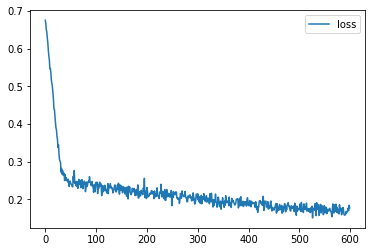

In [17]:
plt.plot(output2,label='loss')
plt.legend()

plt.show()

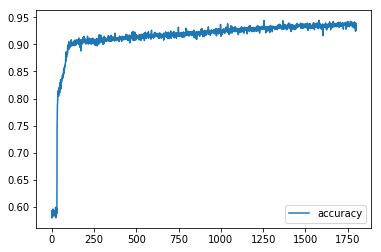

In [18]:
plt.plot(Acc,label = 'accuracy')
plt.legend()

In [19]:
y_prediction = val_out.detach().cpu().numpy()
np_y_pred = np.where(y_prediction < 0.5,0,1)
np_y_true = val_lab.cpu().numpy()

## F1-score

In [20]:
from sklearn.metrics import f1_score
f1_score(np_y_true,np_y_pred)

0.9473684210526316

## Confusion Matrix

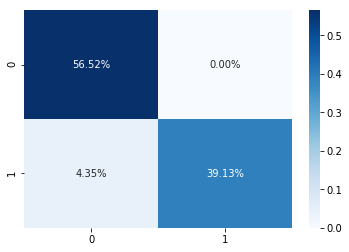

In [21]:
from sklearn.metrics import confusion_matrix
CFM = confusion_matrix(np_y_true,np_y_pred)

import seaborn as sns
sns.heatmap(CFM/np.sum(CFM),annot=True,fmt='.2%',cmap = 'Blues')

## AUC, ROC

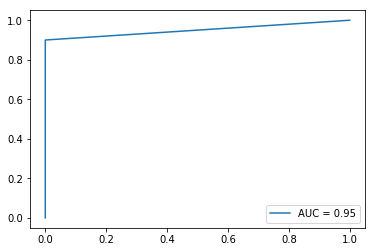

In [22]:
from sklearn.metrics import roc_auc_score,roc_curve

auc =roc_auc_score(np_y_true,np_y_pred)

fpr,tpr,__ = roc_curve(np_y_true,np_y_pred)
plt.plot(fpr,tpr,label = 'AUC = '+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#data = galstar_images.values
#labels = galstar_labels.values
    
data_pre = X.values.reshape(-1,8,26,26)  #griz (psf-g, psf-r,psf-i,psf-z) 8 channels,they claim up to mag27 in the i band

#data_pre[image_number, channel, pixel, pixel]

for i in range(8):
    plt.imshow(data_pre[0,i,:,:],cmap='magma')
    plt.show()

## normalize image

In [ ]:
vec_one_ = np.ones((26,26))
data_post = np.ones((len(data_pre),8,26,26))

def histogramStretch(image):
    min_pixel_val = np.amin(image)
    max_pixel_val = np.amax(image)
    image = image - min_pixel_val * vec_one_        #background subtract
    image = image / (max_pixel_val - min_pixel_val) #normalize between 0 and 1

    assert np.max(image) ==1 and np.min(image) ==0,'check normalization'
    return image

for i in tqdm(range(len(data_pre))):
    for j in range(8):      
        data[i,j,:,:] = histogramStretch(data_pre[i,j,:,:])


In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision as tv
from torch.utils.data import DataLoader,TensorDataset
from torch import Tensor

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

device = torch.device(device)
print(device)

## shuffle, transform to tensor

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
train,test = train_test_split(galstar, stratify = galstar.y,test_size=1 - train_ratio)

X_train, X_test, y_train, y_test = train_test_split(galstar, test_size=(1 - train_ratio))

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
validation,test = train_test_split(test,stratify=test.y,test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
dataset = data_pre
train_label = labels.reshape(-1,1)



data_tensor = TensorDataset(Tensor(dataset),Tensor(train_label))
'''
train_loader = torch.utils.data.DataLoader(dataset = data_tensor,
                                          batch_size = 15899,
                                          shuffle = True,
                                        )
dataiter = iter(train_loader)
img,label = dataiter.next()
'''

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
val_split = 0.01
split = int(np.floor(val_split*dataset_size))





if True:
    np.random.seed(42)
    np.random.shuffle(indices)
train_indices,val_indices = indices[split:],indices[:split]   





print(split)
train_indices,val_indices = indices[split:],indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset = data_tensor,batch_size = 15899,sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(dataset = data_tensor,batch_size = 317,sampler = val_sampler)

In [ ]:
dataiter = iter(val_loader)
img,label = dataiter.next()

## Model

In [ ]:
class BobNet(nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.conv1 = nn.Conv2d(8,16,3,stride = 1,padding=0)#16,24x24 ()
        self.conv2 = nn.Conv2d(16,32,3,stride =1,padding = 0) #22x22,32#  batchnorm
        self.fc1 = nn.Linear(22*22*32,100)
        self.fc2 = nn.Linear(100,20) 
        self.fc3 = nn.Linear(20,1)
        
    def forward(self,x):
        x = torch.nn.functional.relu(self.conv1(x)) #leaky relu, elu
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x =  torch.sigmoid(self.fc3(x)) #binary, 0,1
        
        return x
model = BobNet().to(device)

In [ ]:
from sklearn.metrics import accuracy_score
def eval(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred>0.5)
    return accuracy    

## train

In [ ]:
criterion = nn.BCELoss() 


optimizer = torch.optim.Adam(model.parameters(),lr = 0.0002,weight_decay = 1e-5)

num_epochs = 600
output2 = []
Acc = []
Val=[]

for val_img,val_lab in val_loader:
    val_img,val_lab = val_img.to(device),val_lab.to(device)



for epoch in tqdm(range(num_epochs)):
    for img,lab in train_loader:
     
        
        img = img.to(device)
        lab= lab.to(device)
        
        out = model(img)
        
        val_out = model(val_img)
        valacc = eval(val_lab.cpu(),val_out.cpu())
        Val.append(valacc)
        acc = eval(lab.cpu(),out.cpu())
        

        Acc.append(acc)
        
        loss = criterion(out,lab)
        
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 40 ==0:
  
        print(f'Epoch:{epoch+1},train-acc: {acc*100:.5f}%,val-acc: {valacc*100:.5f}%')        
    
    
    output2.append(loss.item())

In [ ]:
print('best validation accuracy:',np.amax(Val))
print('best training accuracy:',np.amax(Acc))

In [ ]:
plt.plot(output2,label='loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(Acc,label = 'accuracy')
plt.legend()

In [ ]:
y_prediction = out.detach().cpu().numpy()
np_y_pred = np.where(y_prediction < 0.5,0,1)
np_y_true = lab.cpu().numpy()

## F1 score

In [ ]:
from sklearn.metrics import f1_score
f1_score(np_y_true,np_y_pred)

## confusion matrix

In [ ]:

from sklearn.metrics import confusion_matrix
CFM = confusion_matrix(np_y_true,np_y_pred)

import seaborn as sns
sns.heatmap(CFM/np.sum(CFM),annot=True,fmt='.2%',cmap = 'Blues')

## AUC ,ROC

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

auc =roc_auc_score(np_y_true,np_y_pred)

fpr,tpr,__ = roc_curve(np_y_true,np_y_pred)
plt.plot(fpr,tpr,label = 'AUC = '+str(auc))
plt.legend(loc=4)
plt.show()